In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow import keras
import urllib.request, zipfile
import json
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv(r"C:\Users\shez8\Desktop\fakenewslstm-main\train.csv")
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
df['title'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

In [5]:
df['text'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing emai

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [7]:
# drop unnecessary columns
df = df.drop(columns=['id', 'title', 'author'], axis=1)

In [8]:
# drop null values
df = df.dropna(axis=0)

In [9]:
len(df)

20761

In [10]:
df['clean_news'] = df['text'].str.lower()
df['clean_news'] = df['clean_news'].str.replace('[^A-Za-z0-9\s]', '', regex=True)
df['clean_news'] = df['clean_news'].str.replace('\n', '', regex=True)
df['clean_news'] = df['clean_news'].str.replace('\s+', ' ', regex=True)
df['clean_news']

0        house dem aide we didnt even see comeys letter...
1        ever get the feeling your life circles the rou...
2        why the truth might get you fired october 29 2...
3        videos 15 civilians killed in single us airstr...
4        print an iranian woman has been sentenced to s...
                               ...                        
20795    rapper t i unloaded on black celebrities who m...
20796    when the green bay packers lost to the washing...
20797    the macys of today grew from the union of seve...
20798    nato russia to hold parallel exercises in balk...
20799     david swanson is an author activist journalis...
Name: clean_news, Length: 20761, dtype: object

In [44]:
# remove stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['clean_news'] = df['clean_news'].apply(
    lambda x: " ".join([word for word in x.split() if word not in stop])
)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shez8\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['clean_news'].values, df['label'].values,
    test_size=0.3, random_state=42, stratify=df['label']
)

In [46]:
# tokenize text
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
vocab_size

151891

In [47]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train_text), maxlen=400, padding='post', truncating='post')
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test_text),  maxlen=400, padding='post', truncating='post')

In [48]:
'''
import urllib.request
import zipfile

# Download GloVe zip file
url = "http://nlp.stanford.edu/data/glove.6B.zip"
urllib.request.urlretrieve(url, "glove.6B.zip")

# Unzip it
with zipfile.ZipFile("glove.6B.zip", "r") as zip_ref:
    zip_ref.extractall("glove")
'''


'\nimport urllib.request\nimport zipfile\n\n# Download GloVe zip file\nurl = "http://nlp.stanford.edu/data/glove.6B.zip"\nurllib.request.urlretrieve(url, "glove.6B.zip")\n\n# Unzip it\nwith zipfile.ZipFile("glove.6B.zip", "r") as zip_ref:\n    zip_ref.extractall("glove")\n'

In [49]:
# create embedding index
embedding_index = {}
EMB_TXT = "./glove/glove.6B.100d.txt"
with open(EMB_TXT, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

In [50]:
# Create embedding matrix
embedding_dim = 100
embedding_matrix = np.random.normal(scale=0.6, size=(vocab_size, embedding_dim)).astype('float32')
embedding_matrix[0] = 0.0  # padding row

for word, idx in word_index.items():
    vec = embedding_index.get(word)
    if vec is not None:
        embedding_matrix[idx] = vec

In [51]:
embedding_matrix[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [52]:
embedding_matrix[1]

array([ 1.1944816 , -0.19897497, -0.0225082 , -1.0713238 , -0.75761557,
       -0.05092215,  0.7081171 ,  0.81262684,  0.03138322,  0.35232434,
        0.33116865,  0.41806957,  0.754701  ,  0.48677686,  0.27842855,
        0.04394649,  0.29470402,  0.42656633,  0.18611638, -0.03708836,
       -0.7056085 , -0.7965292 , -0.41247943, -0.5914043 ,  0.03030873,
        0.07087255,  0.4910234 ,  0.93341464,  0.87669116,  0.83492726,
       -1.1420298 ,  0.03553353,  1.6975635 , -0.5501687 , -0.21452692,
        0.388448  , -1.1394242 , -0.23377512,  1.1392987 ,  0.04873183,
       -0.06308682,  1.0422906 , -0.607235  , -1.45919   , -0.66588044,
       -0.7241191 , -0.9741179 ,  0.06832953,  0.48033258, -0.01288495,
       -0.03029329, -0.97916126,  0.39496446, -0.50893533, -0.22210734,
       -0.49866286,  1.1894418 ,  0.17029074,  0.22020386,  0.00319823,
       -0.6015236 , -0.367986  ,  1.0297025 , -0.09711115,  0.5156208 ,
       -0.8512979 , -0.8504646 , -0.6007021 ,  0.34238657, -0.07

In [53]:
from keras import Sequential, layers

model = Sequential([
    layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False, input_length=400),
    layers.SpatialDropout1D(0.2),
    layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

In [54]:
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=2e-4),
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │    15,189,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,189,100 (57.94 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 15,189,100 (57.94 MB)

In [55]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_auc', mode='max'),
    keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_auc', mode='max')
]

In [56]:
# train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10, batch_size=128,
    callbacks=callbacks, verbose=1
)

Epoch 1/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.5939 - auc: 0.6236 - loss: 0.6726 - val_accuracy: 0.6433 - val_auc: 0.6755 - val_loss: 0.6347
Epoch 2/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.6474 - auc: 0.6815 - loss: 0.6310 - val_accuracy: 0.6876 - val_auc: 0.7439 - val_loss: 0.5939
Epoch 3/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.6667 - auc: 0.7321 - loss: 0.6060 - val_accuracy: 0.6829 - val_auc: 0.7761 - val_loss: 0.5640
Epoch 4/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.6796 - auc: 0.7468 - loss: 0.5918 - val_accuracy: 0.7138 - val_auc: 0.7721 - val_loss: 0.5654
Epoch 5/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.6760 - auc: 0.7298 - loss: 0.6022 - val_accuracy: 0.7059 - val_auc: 0.7853 - val_loss: 0.5769
Epoch 6/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.6827 - auc: 0.7494 - loss: 0.5911 - val_accuracy: 0.7107 - val_auc: 0.7950 - val_loss: 0.5531
Epoch 7/10
114/114 ━━━━━━━━━━━━━━━

In [57]:
import pickle
with open("history.pkl", "wb") as f:
    pickle.dump(history.history, f)

model.save("final_model.keras")

with open("tokenizer.json", "w") as f:
    f.write(tokenizer.to_json())

In [58]:
# from tensorflow import keras
# model = keras.models.load_model("my_model.h5")
# with open("history.pkl", "rb") as f:
#     history = pickle.load(f)

In [59]:
y_pred = model.predict(X_test).ravel()  # flatten to 1D

mse = np.mean((y_test - y_pred) ** 2)
rmse = np.sqrt(mse)

print(f"MSE (probabilities): {mse:.4f}")
print(f"RMSE (probabilities): {rmse:.4f}")

195/195 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step
MSE (probabilities): 0.1809
RMSE (probabilities): 0.4253


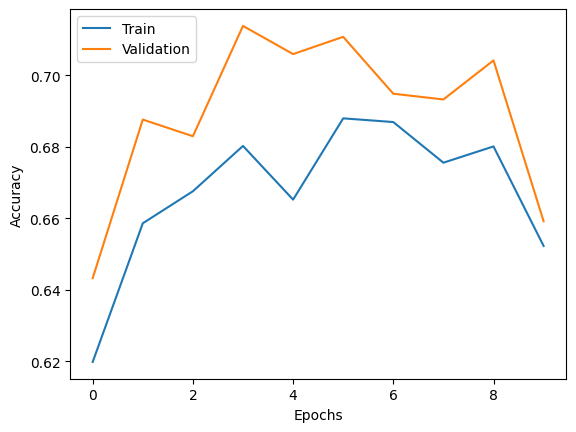

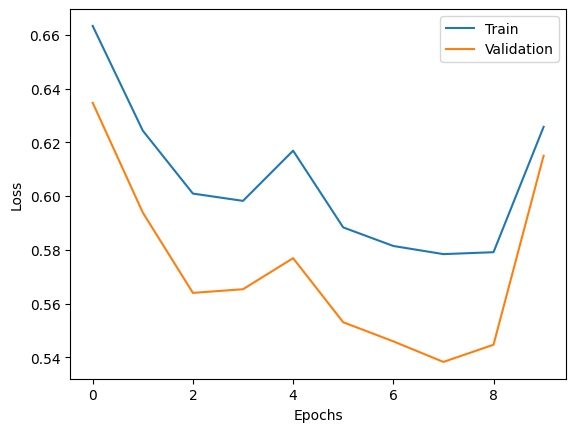

In [60]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()